# Tax units with lowest after-tax after-transfer incomes

This notebook analyzes the distribution of tax units and individuals with the lowest after-tax after-transfer incomes. It compares Tax-Calculator's CPS + C-TAM data for the very bottom of the income scales, given the controversy around shares of Americans living in extreme poverty.

For example, Tax-Calculator estimates that 0.9M tax units with children have incomes below \$2 per person per day, and that these tax units include 1.4M children. http://www.twodollarsaday.com/ has said:

> the number of American families living on $2.00 per person, per day, has skyrocketed to one and a half million American households, including about three million children.

But this analysis has come under some criticism for not accounting for all transfer programs and time spent in poverty. Given Tax-Calculator results are annual, the primary comparison is against other annual surveys, as incomes can vary by month. 

For example, Tax-Calculator says that 1.5% of the population is in tax units with total income under $2 per person per day. Depending on the source, consumption vs. income, and time period (not always known), other sources estimate this share between 0% and 2.1%. This notebook focuses on research from a [Brookings Institution report](https://www.brookings.edu/wp-content/uploads/2016/06/How-Poor-are-Americas-Poorest.pdf) examining these other sources.

These other sources could be used to calibrate the C-TAM model.

*Data: CPS  |  Tax year: 2014  |  Author: Max Ghenis  |  Date run: 2018-02-27*

## Setup

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'0.16.1'

In [3]:
sns.set_style('whitegrid')

DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi']= DPI

mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
sns.set_palette(sns.color_palette())

## Generate data

### Tax-Calculator

Use 2014 data (i.e., don't `advance_to_year`) since comparison data points are in 2011-2012.

In [4]:
recs = tc.Records.cps_constructor()
calc = tc.Calculator(records=recs, policy=tc.Policy())
calc.calc_all()

You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.


Create `DataFrame` of the items desired.

Which relevant columns are available? Totals, but really just care about != 0.

In [5]:
df = calc.dataframe(['s006',
                     'aftertax_income',
                     'nu18',
                     'XTOT'
                    ])

### Other sources

Create `DataFrame`s of other sources, in the order described in [Smith and Chandy](https://www.brookings.edu/wp-content/uploads/2016/06/How-Poor-are-Americas-Poorest.pdf) of Brookings.

Survey of Income and Program Participation (SIPP):

> Initiated in 1976, the SIPP was specifically designed to overcome some of the known limitations
of the Current Population Survey, the source of the official poverty rate, that disproportionately affect
the estimation of incomes for poor households. These include the underreporting of participation in government
welfare programs and unreliable estimates of irregular sources of income. Evidence confirms that the
SIPP obtains the highest estimates of income among low-income households and the most accurate reporting of
government program participation among comparable surveys.

Smith and Chandy use 2012 SIPP data in their Brookings paper. Their first two charts show responses at a particular time, so are not comparable to annual Tax-Calculator data. This shows that data:

In [6]:
# Estimated from Figure 1.
sipp_snapshot = pd.DataFrame({'amount': [0, 1.25, 2], 
                              'pop_share': [0.014, 0.026, 0.028]})

The 12-month estimates, which come from Figure 3 and this paragraph:

> Figure 3 illustrates this point. There is a dramatic decrease in those reporting no income and benefits when the
reporting period is increased from one month to 12 months, as employed in the official U.S. poverty measure.
This drives a reduction in our broad measure of $2 poverty: from 4 percent using survey responses over a single
month, to 3 percent when responses are averaged over 4 months, to under 2 percent when responses are
aggregated over a year.

I'll assume 1.9% where they say "under 2 percent."

In [7]:
sipp = pd.DataFrame({'amount': [0, 2],
                     'pop_share': [0.002, 0.019]})

Supplemental Poverty Measure, described in Brookings (2011 data). It does not say what the period was, so this is unlikely to be a comparable 12-month estimate. I've asked on Chandy on Twitter [here](https://twitter.com/MaxGhenis/status/968959029773983744).

In [8]:
spm = pd.DataFrame({'amount': [1.25, 2],
                    'pop_share': [0.019, 0.021]})

The [Consumer Expenditure Survey](https://www.bls.gov/cex/):

> ...which in contrast to the previous two surveys measures consumption as opposed to income, dates back to 1980
and is conducted principally for the purpose of computing weights of the Consumer Price Index. 

Results are from this paragraph in Smith and Chandy:

> Based on an assessment of consumption in the fourth quarter of 2011, we obtain a much lower $2 a day poverty
rate of only 0.07 percent.

and [this CGD article](https://www.cgdev.org/blog/chart-week-4-angus-deaton-location-poverty?utm_content=buffer57f8d&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer):

> Thanks to rapid and generous sharing of data and code by Chandy and Smith, we’re able to use their analysis to see how many Americans are consumption poor at Deaton’s preferred $4 cutoff. The estimate is 0.22 percent compared to Deaton’s income-based estimate of 1.7 percent.

In [9]:
ce = pd.DataFrame({'amount': [2, 4], 
                   'pop_share': [0.0007, 0.0022]})

Chandy and Smith also use the World Bank approach of fitting a Lorenz curve to the distribution of responses to estimate poverty:

> When we replicate this process using data from the U.S. CEX, our estimate of $2 a day poverty falls all the way
to zero.

In [10]:
ce_lorenz = pd.DataFrame({'amount': [2],
                          'pop_share': [0]})

## Preprocessing

Remove negatives.

In [11]:
df = df[df['aftertax_income'] >= 0]

Add after-tax income per person per day.

In [12]:
df['aftertax_income_pppd'] = df['aftertax_income'] / (df['XTOT'] * 365)
df['XTOT_s006'] = df['XTOT'] * df['s006']
df['nu18_s006'] = df['nu18'] * df['s006']
df['s006_with_children'] = np.where(df['nu18'] > 0, df['s006'], 0)

Add % of total.

In [13]:
df['XTOT_s006_pct'] = df['XTOT_s006'] / df['XTOT_s006'].sum()
df['s006_pct'] = df['s006'] / df['s006'].sum()
df['nu18_s006_pct'] = df['nu18_s006'] / df['nu18_s006'].sum()
df['s006_with_children_pct'] = df['s006_with_children'] / df['s006_with_children'].sum()

Add after-tax income percentile by sorting and summing `cumsum` of normalized weight.

In [14]:
df.sort_values(by=['aftertax_income_pppd'], inplace=True)
df['XTOT_s006_cumsum'] = df['XTOT_s006'].cumsum()
df['s006_cumsum'] = df['s006'].cumsum()
df['nu18_s006_cumsum'] = df['nu18_s006'].cumsum()
df['s006_with_children_cumsum'] = df['s006_with_children'].cumsum()

df['XTOT_s006_cumpct'] = df['XTOT_s006_pct'].cumsum()
df['s006_cumpct'] = df['s006_pct'].cumsum()
df['nu18_s006_cumpct'] = df['nu18_s006_pct'].cumsum()
df['s006_with_children_cumpct'] = df['s006_with_children_pct'].cumsum()

## Analysis

### Per person, compared to other sources

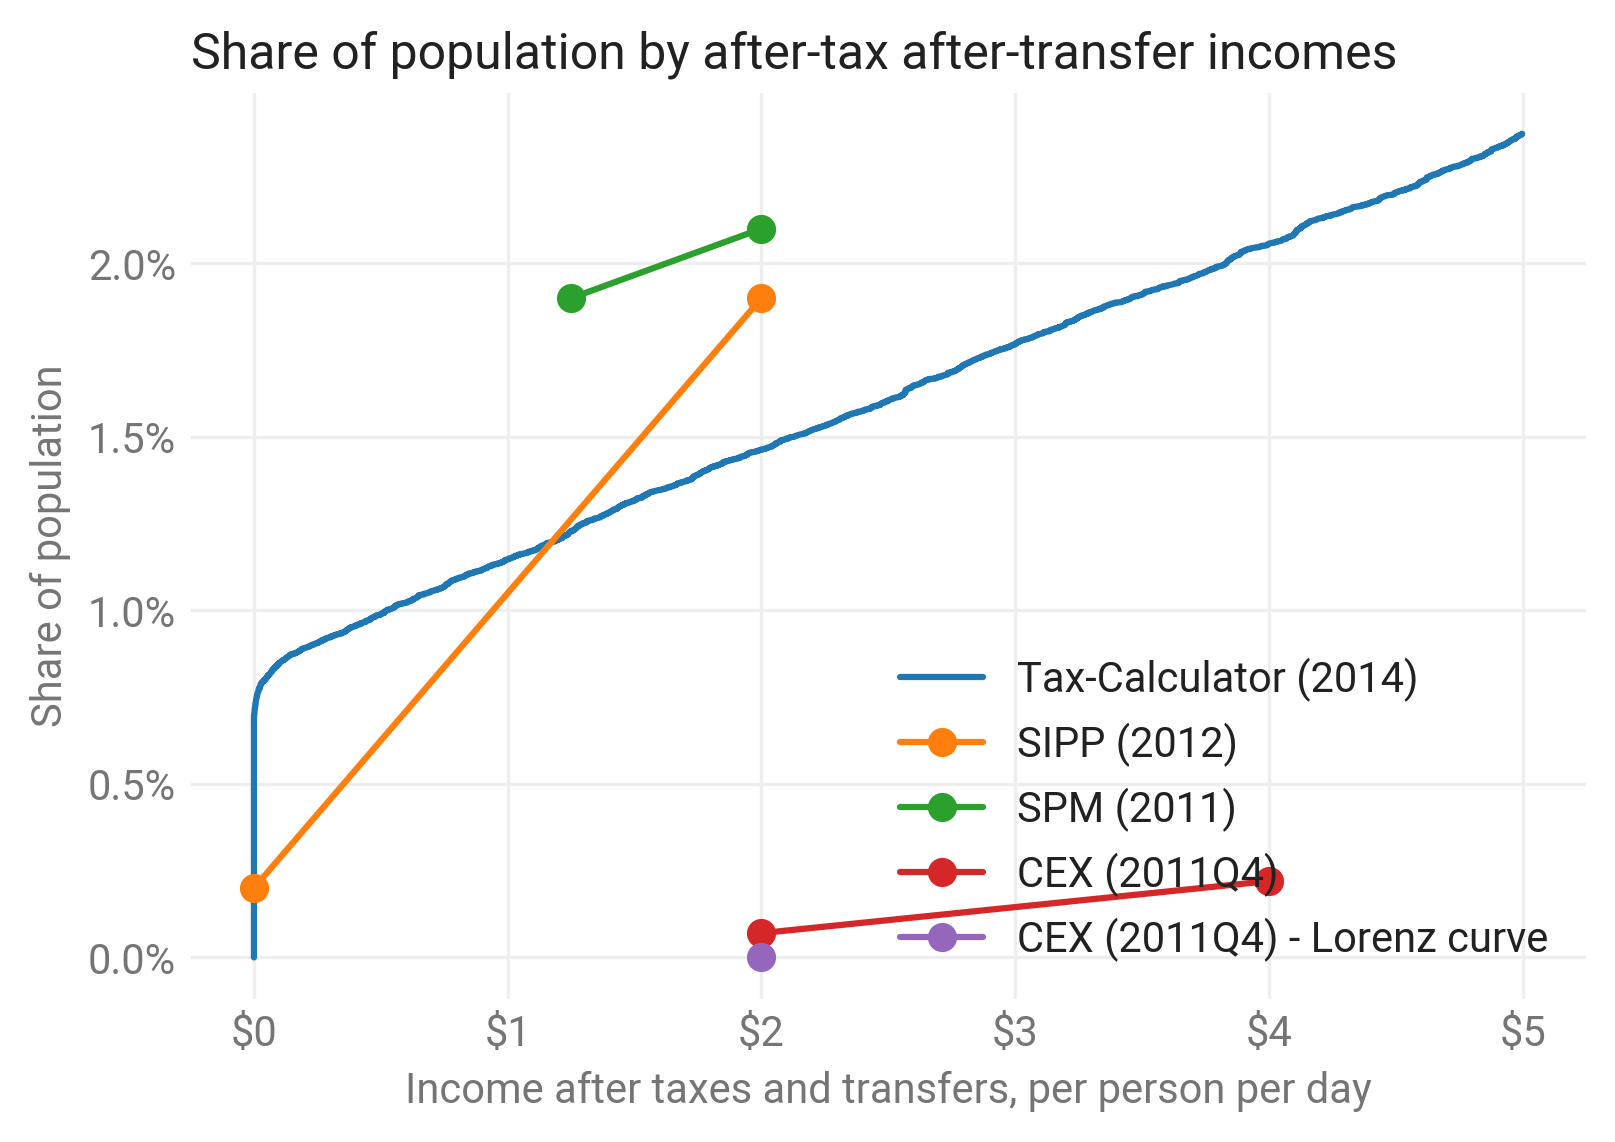

In [15]:
ax = df[df['aftertax_income_pppd'] <= 5].plot(
    x='aftertax_income_pppd', y='XTOT_s006_cumpct')
sipp.plot(x='amount', y='pop_share', marker='o', ax=ax)
spm.plot(x='amount', y='pop_share', marker='o', ax=ax)
ce.plot(x='amount', y='pop_share', marker='o', ax=ax)
ce_lorenz.plot(x='amount', y='pop_share', marker='o', ax=ax)
ax.legend(['Tax-Calculator (2014)', 'SIPP (2012)', 'SPM (2011)',
           'CEX (2011Q4)', 'CEX (2011Q4) - Lorenz curve'])
ax.grid(color='#eeeeee')
sns.despine(left=True, bottom=True)
ax.set(xlabel='Income after taxes and transfers, per person per day',
       ylabel='Share of population')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: '$' + format(int(x))))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.title('Share of population by after-tax after-transfer incomes', loc='left')
plt.show()

### Per tax unit, person, and child

Absolute counts and shares of total.

TODO: Avoid warning (https://github.com/pandas-dev/pandas/issues/18764).

/usr/local/google/home/mghenis/miniconda2/lib/python2.7/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


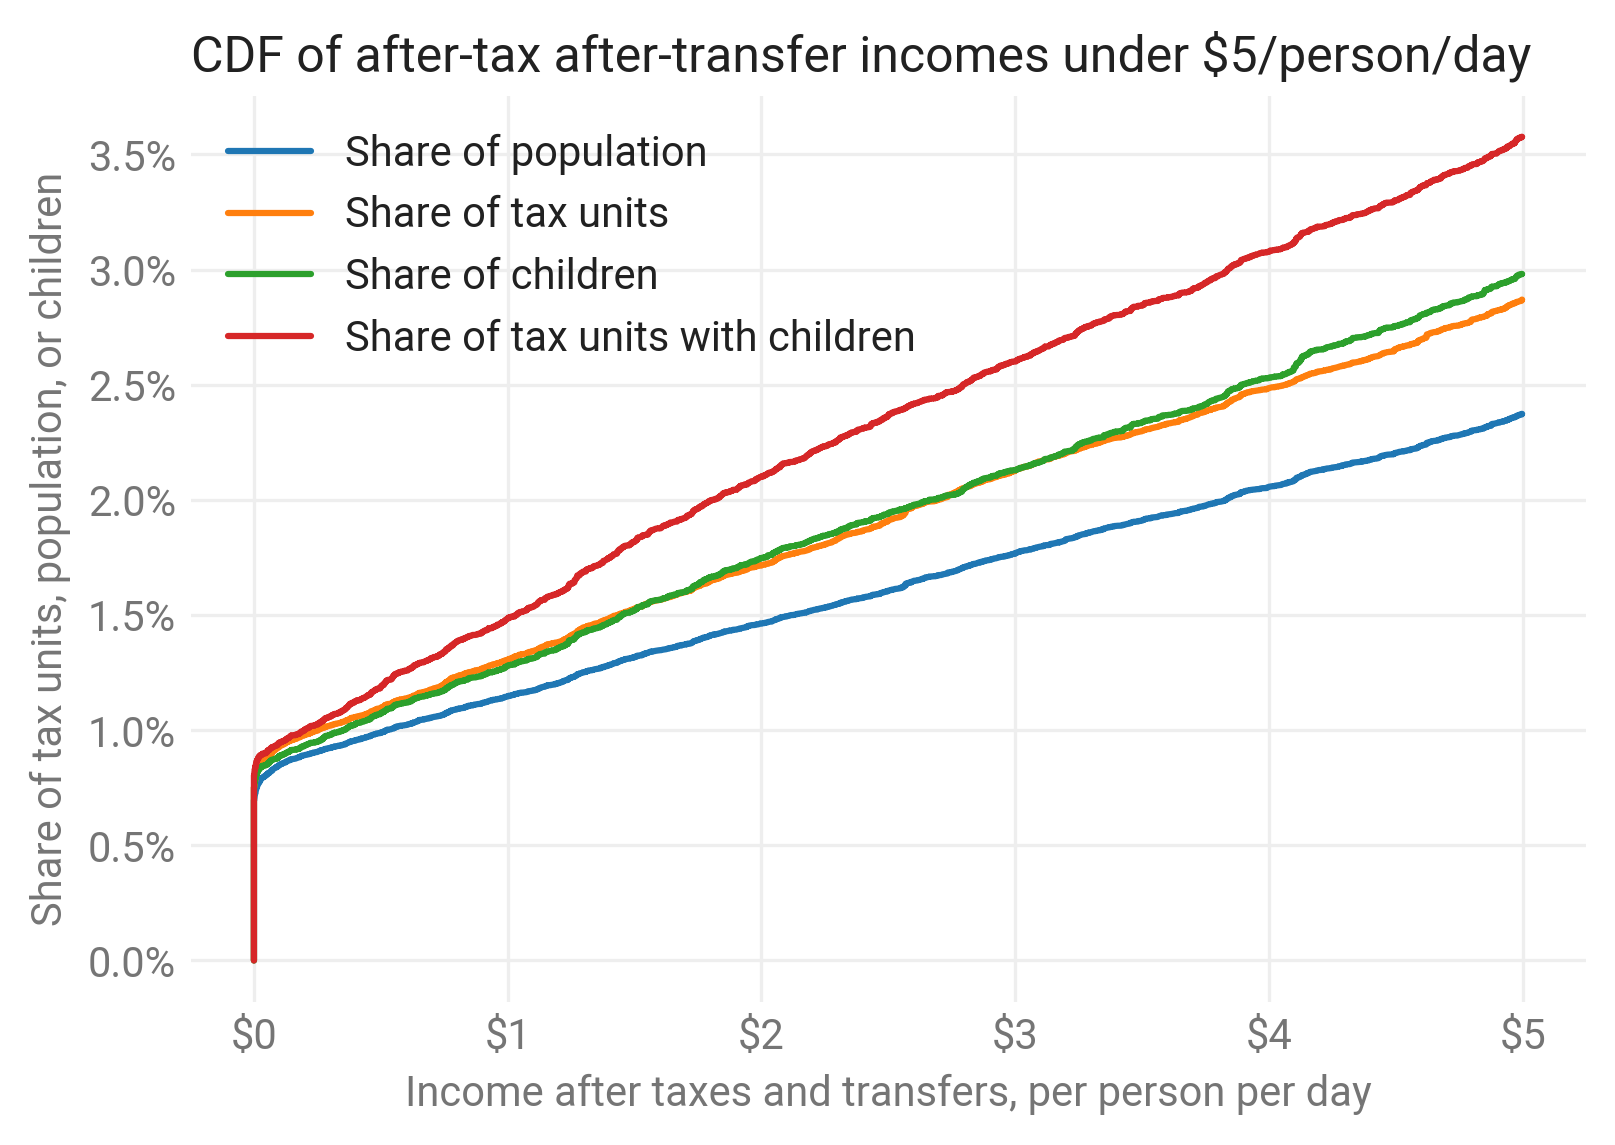

In [16]:
ax = df[df['aftertax_income_pppd'] <= 5].plot(
    x='aftertax_income_pppd', 
    y=['XTOT_s006_cumpct', 's006_cumpct', 'nu18_s006_cumpct', 's006_with_children_cumpct'])
ax.legend(['Share of population', 'Share of tax units', 'Share of children',
           'Share of tax units with children'])
ax.grid(color='#eeeeee')
sns.despine(left=True, bottom=True)
ax.set(xlabel='Income after taxes and transfers, per person per day',
       ylabel='Share of tax units, population, or children')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: '$' + format(int(x))))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.title('CDF of after-tax after-transfer incomes under $5/person/day', loc='left')
plt.show()

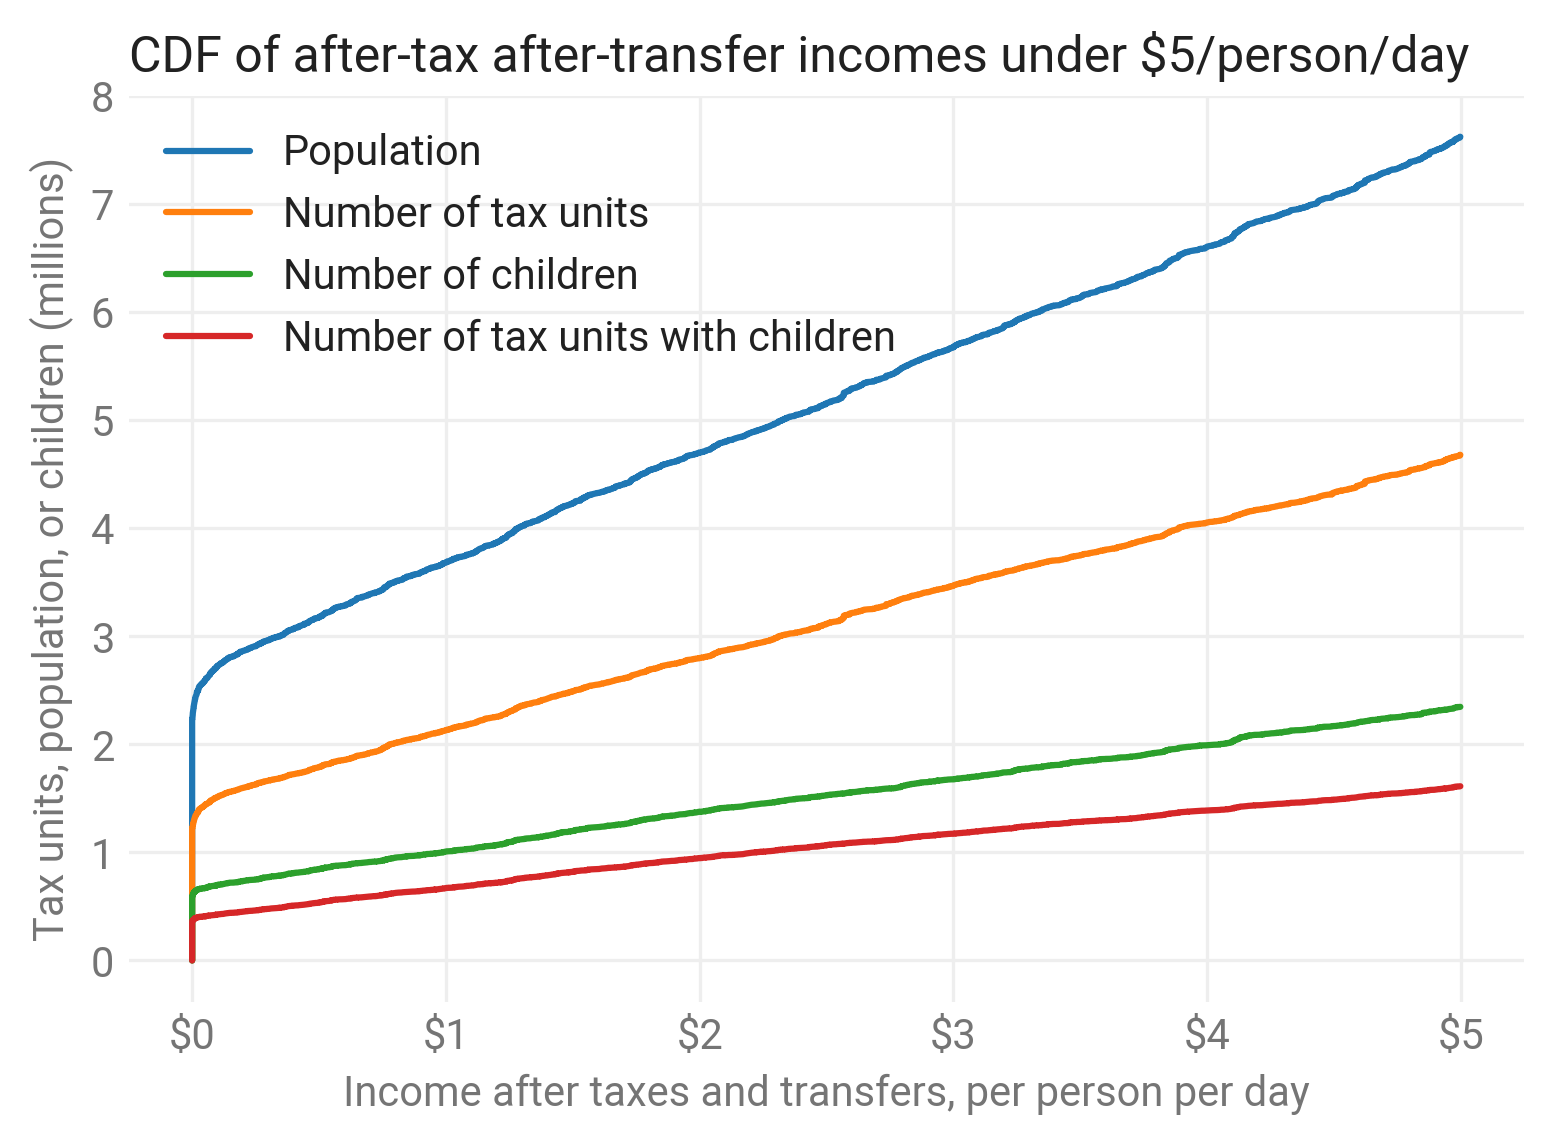

In [17]:
ax = df[df['aftertax_income_pppd'] <= 5].plot(
    x='aftertax_income_pppd', 
    y=['XTOT_s006_cumsum', 's006_cumsum', 'nu18_s006_cumsum', 's006_with_children_cumsum'])
ax.legend(['Population', 'Number of tax units', 'Number of children',
           'Number of tax units with children'])
ax.grid(color='#eeeeee')
sns.despine(left=True, bottom=True)
ax.set(xlabel='Income after taxes and transfers, per person per day',
       ylabel='Tax units, population, or children (millions)')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: '$' + format(int(x))))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: (y / 1e6).astype(int)))
plt.title('CDF of after-tax after-transfer incomes under $5/person/day', loc='left')
plt.show()

### Tables

Specific thresholds: \$2/day and \$4/day.

In [18]:
(df.loc[df['aftertax_income_pppd'] <= 2, 
        ['s006', 'XTOT_s006', 'nu18_s006', 's006_with_children']].sum() / 1e6).round(1)

s006                  2.8
XTOT_s006             4.7
nu18_s006             1.4
s006_with_children    0.9
dtype: float64

In [19]:
(df.loc[df['aftertax_income_pppd'] <= 2, 
        ['s006_pct', 'XTOT_s006_pct', 'nu18_s006_pct', 
         's006_with_children_pct']].sum() * 100).round(1)

s006_pct                  1.7
XTOT_s006_pct             1.5
nu18_s006_pct             1.7
s006_with_children_pct    2.1
dtype: float64

In [20]:
(df.loc[df['aftertax_income_pppd'] <= 4, 
        ['s006_pct', 'XTOT_s006_pct', 'nu18_s006_pct', 
         's006_with_children_pct']].sum() * 100).round(1)

s006_pct                  2.5
XTOT_s006_pct             2.1
nu18_s006_pct             2.5
s006_with_children_pct    3.1
dtype: float64